In [1]:
import torch, torchvision
import torch.nn as nn
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import torchvision.transforms as transforms
from torchvision.models import vgg11
import numpy as np
from torch.nn import functional as F
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
import backpack
from torch.nn import CrossEntropyLoss, Linear
#from utils import load_mnist_data
from backpack import extend, backpack
from backpack.extensions import KFAC
import argparse
s=2
np.random.seed(s)
torch.manual_seed(s)
torch.cuda.manual_seed(s)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Data wrangling

In [2]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


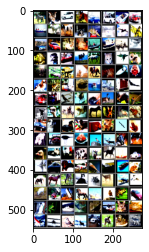

horse   cat   car horse


In [3]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# VGG Network

In [15]:
pt_vgg11 = vgg11(pretrained=False)
print(pt_vgg11)
#from vgg_pytorch import VGG

#pretainedvgg11 = VGG.from_pretrained('vgg11', num_classes=10)
#print(pretainedvgg11)




VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [5]:
def VGG11(num_classes=10):
    
    features = torch.nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
        nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
        nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(inplace=True),
        nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
        nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
        nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
        nn.AdaptiveAvgPool2d(output_size=(7, 7)),
        nn.Flatten(),
        nn.Linear(512 * 7 * 7, 4096, bias=True),
        nn.ReLU(True),
        nn.Dropout(p=0.2, inplace=False),
        nn.Linear(4096, 4096, bias=True),
        nn.ReLU(True),
        nn.Dropout(p=0.2, inplace=False),
        nn.Linear(4096, num_classes, bias=True)
    )
    return(features)

In [6]:
vgg11_model = VGG11()

vgg11_model = vgg11_model.to(device)
if device == 'cuda':
    vgg11_model = torch.nn.DataParallel(vgg11_model)
    cudnn.benchmark = True

#print(vgg11_model)
loss_function = nn.CrossEntropyLoss()

cifar10_train_optimizer = torch.optim.SGD(vgg11_model.parameters(), lr=0.1,
                      momentum=0.9, weight_decay=5e-4)

VGG_PATH = "../VGGtrained_weights/CIFAR10/CIFAR10_weights_seed={}.pth".format(s)

In [12]:
state = torch.load('/Users/moreez/Desktop/BcThesis/GitHub/BcThesisMK/Moritz_folder/Notebooks/VGG/trained_weights/checkpoint/ckpt_seed2.pth', map_location=torch.device('cpu'))

In [14]:
print(state['acc'])

16.27


In [36]:
#try to load pretrained weights into Sequential
weights = pretainedvgg11.state_dict()
vgg11_model.load_state_dict(state['net'], strict=False)
vgg11_model.eval()

acc = []

max_len = len(testloader)
for batch_idx, (x, y) in enumerate(testloader):
        output = vgg11_model(x)
        accuracy = get_accuracy(output, y)
        if batch_idx % 100 == 0:
            print(
                "Batch {}/{} \t".format(batch_idx, max_len) + 
                "Accuracy %.0f" % (accuracy * 10) + "%"
            )
        acc.append(accuracy)
    
avg_acc = np.mean(acc)
print('overall test accuracy on CIFAR10: {:.02f} %'.format(avg_acc * 100))

Batch 0/100 	Accuracy 1%
overall test accuracy on CIFAR10: 10.00 %


In [9]:
def get_accuracy(output, targets):
    """Helper function to print the accuracy"""
    predictions = output.argmax(dim=1, keepdim=True).view_as(targets)
    return predictions.eq(targets).float().mean().item()



In [16]:
#TRAINING ROUTINE
"""
def train(verbose=False, num_iter=5):
    max_len = len(trainloader)
    for epoch in range(num_iter):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            cifar10_train_optimizer.zero_grad()

            # forward + backward + optimize
            outputs = vgg11_model(inputs)
            accuracy = get_accuracy(outputs, labels)
            loss = loss_function(outputs, labels)
            loss.backward()
            cifar10_train_optimizer.step()

            # print statistics
            running_loss += loss.item()
            #if i % 2000 == 1999:    # print every 2000 mini-batches
            #print('[%d, %5d] loss: %.3f' %
            #(epoch + 1, i + 1, running_loss / 2000))
            #running_loss = 0.0
            if verbose:
                if i % 10 == 0:
                    print(
                        "Iteration {}; {}/{} \t".format(epoch, i, max_len) +
                        "Minibatch Loss %.3f  " % (loss) +
                        "Accuracy %.0f" % (accuracy * 100) + "%"
                    )



    print('Finished Training')
    print("saving model at: {}".format(VGG_PATH))
    torch.save(vgg11_model.state_dict(), VGG_PATH)
"""

'\ndef train(verbose=False, num_iter=5):\n    max_len = len(trainloader)\n    for epoch in range(num_iter):  # loop over the dataset multiple times\n\n        running_loss = 0.0\n        for i, data in enumerate(trainloader, 0):\n            # get the inputs; data is a list of [inputs, labels]\n            inputs, labels = data\n\n            # zero the parameter gradients\n            cifar10_train_optimizer.zero_grad()\n\n            # forward + backward + optimize\n            outputs = vgg11_model(inputs)\n            accuracy = get_accuracy(outputs, labels)\n            loss = loss_function(outputs, labels)\n            loss.backward()\n            cifar10_train_optimizer.step()\n\n            # print statistics\n            running_loss += loss.item()\n            #if i % 2000 == 1999:    # print every 2000 mini-batches\n            #print(\'[%d, %5d] loss: %.3f\' %\n            #(epoch + 1, i + 1, running_loss / 2000))\n            #running_loss = 0.0\n            if verbose:\n 

In [39]:
train(verbose=True)

Iteration 0; 0/12500 	Minibatch Loss 2.287  Accuracy 25%
Iteration 0; 10/12500 	Minibatch Loss 2.280  Accuracy 0%
Iteration 0; 20/12500 	Minibatch Loss 2.307  Accuracy 0%
Iteration 0; 30/12500 	Minibatch Loss 2.267  Accuracy 25%
Iteration 0; 40/12500 	Minibatch Loss 2.338  Accuracy 0%
Iteration 0; 50/12500 	Minibatch Loss 2.315  Accuracy 25%
Iteration 0; 60/12500 	Minibatch Loss 2.251  Accuracy 0%
Iteration 0; 70/12500 	Minibatch Loss 2.288  Accuracy 0%
Iteration 0; 80/12500 	Minibatch Loss 2.352  Accuracy 0%
Iteration 0; 90/12500 	Minibatch Loss 2.218  Accuracy 75%
Iteration 0; 100/12500 	Minibatch Loss 2.292  Accuracy 25%
Iteration 0; 110/12500 	Minibatch Loss 2.278  Accuracy 0%
Iteration 0; 120/12500 	Minibatch Loss 2.303  Accuracy 25%
Iteration 0; 130/12500 	Minibatch Loss 2.327  Accuracy 0%
Iteration 0; 140/12500 	Minibatch Loss 2.290  Accuracy 0%
Iteration 0; 150/12500 	Minibatch Loss 2.269  Accuracy 25%
Iteration 0; 160/12500 	Minibatch Loss 2.322  Accuracy 0%
Iteration 0; 170/1

KeyboardInterrupt: 

In [16]:
'''
Modified from https://github.com/pytorch/vision.git
'''
import math

import torch.nn as nn
import torch.nn.init as init

__all__ = [
    'VGG', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn',
    'vgg19_bn', 'vgg19',
]


class VGG(nn.Module):
    '''
    VGG model 
    '''
    def __init__(self, features):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, 10),
        )
         # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()


    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 
          512, 512, 512, 512, 'M'],
}


def vgg11():
    """VGG 11-layer model (configuration "A")"""
    return VGG(make_layers(cfg['A']))


def vgg11_bn():
    """VGG 11-layer model (configuration "A") with batch normalization"""
    return VGG(make_layers(cfg['A'], batch_norm=True))


def vgg13():
    """VGG 13-layer model (configuration "B")"""
    return VGG(make_layers(cfg['B']))


def vgg13_bn():
    """VGG 13-layer model (configuration "B") with batch normalization"""
    return VGG(make_layers(cfg['B'], batch_norm=True))


def vgg16():
    """VGG 16-layer model (configuration "D")"""
    return VGG(make_layers(cfg['D']))


def vgg16_bn():
    """VGG 16-layer model (configuration "D") with batch normalization"""
    return VGG(make_layers(cfg['D'], batch_norm=True))


def vgg19():
    """VGG 19-layer model (configuration "E")"""
    return VGG(make_layers(cfg['E']))


def vgg19_bn():
    """VGG 19-layer model (configuration 'E') with batch normalization"""
    return VGG(make_layers(cfg['E'], batch_norm=True))

In [18]:
vet11 = vgg11()
print(vet11)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [23]:
'''VGG11/13/16/19 in Pytorch.'''
import torch
import torch.nn as nn


cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)


def test():
    net = VGG('VGG11')
    x = torch.randn(2,3,32,32)
    y = net(x)
    print(y.size())
    print(net)

test()


torch.Size([2, 10])
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
  

AttributeError: module 'torch.nn' has no attribute 'Reshape'